In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [3]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [4]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position = 1 / fcen
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + 1/fcen
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [5]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [6]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [7]:
offset = 0.01
flux_size = 0.02

input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

out_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
            center=mp.Vector3(0, center_y_monitor_position),
                    size=mp.Vector3(2*1/fcen,0,0),
                    # direction=mp.Y
                    )
    )

In [8]:
dft_fields = sim.add_dft_fields([mp.Ez], fcen, 0, 1, 
                                    center = mp.Vector3(0, center_y_monitor_position),
                                    size = mp.Vector3(design_region_width,0,0), 
                                    yee_grid=True)

-----------
Initializing structure...
time for choose_chunkdivision = 5.72205e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.058054 s
time for set_conductivity = 0.0023551 s
time for set_condu

<Axes: xlabel='X', ylabel='Y'>

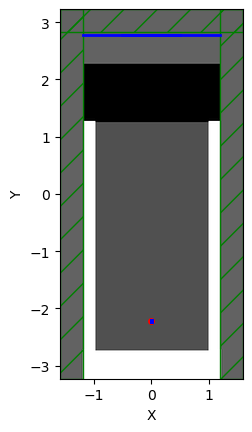

In [9]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))
# sim.run(until=10)
# sim.plot2D(output_plane=mp.Volume(center = sources.center, size = mp.Vector3(0.1,0.1)))
sim.plot2D()
# external_flux = mp.get_fluxes(out_flux)
# box_flux = mp.get_fluxes(input_flux)

# np.array(external_flux) / np.array(box_flux) * 100

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

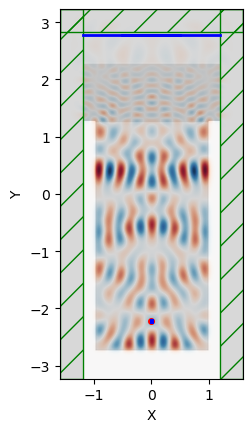

In [10]:
sim.plot2D(fields = mp.Ez)

In [11]:
external_flux = mp.get_fluxes(out_flux)
box_flux = mp.get_fluxes(input_flux)

np.array(external_flux) / np.array(box_flux) * 100

array([17.0813335])

In [16]:
dft_fields_array = sim.get_dft_array( dft_fields, mp.Ez, 0)

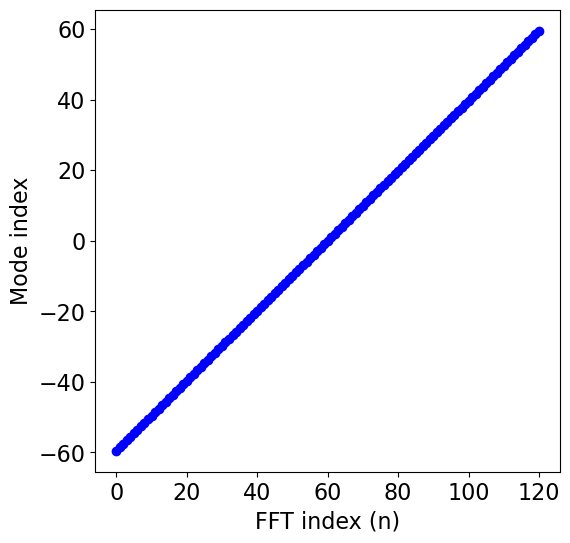

121


In [17]:
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))
mode = kx*(design_region_width/(2*np.pi))

plt.figure(figsize=(6,6))
plt.plot(mode, 'bo')
plt.xlabel('FFT index (n)', fontsize = fontlabel) 
plt.ylabel('Mode index', fontsize = fontlabel)

plt.xticks(fontsize = fontlabel)
plt.yticks(fontsize = fontlabel)

plt.show()
print(len(mode))

/tmp/ipykernel_17208/2535843175.py:20: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(kx / k0)       # 라디안


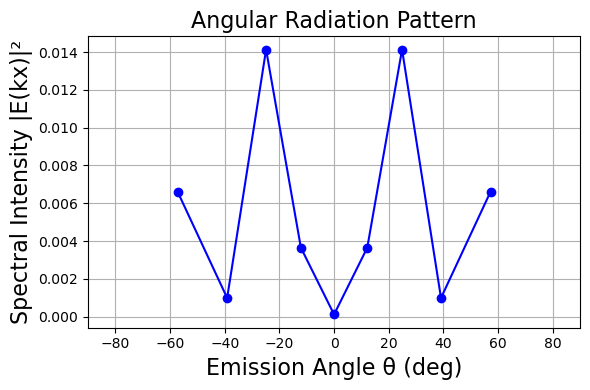

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 1) DFT 필드 (complex 1D array)
E  = dft_fields_array
N  = len(E)
dx = 1.0 / resolution      # 공간 샘플 간격
k0 = 2 * np.pi * fcen      # 진공 파수

# 2) kx 벡터 (rad/unit 길이)
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# 3) 공간 FFT → E(kx)
E_k = np.fft.fftshift(np.fft.fft(E)) / N

# 4) 스펙트럼 세기
I_k = np.abs(E_k)**2

# 5) 각도 변환 (클립 없이)
theta = np.arcsin(kx / k0)       # 라디안
theta_deg = np.degrees(theta)    # 도 단위

# 6) 전파 모드(실수 θ)만 골라내기
mask = np.isfinite(theta_deg)    # |kx|>k0 구간은 nan → False

# 7) 플롯
plt.figure(figsize=(6,4))
plt.plot(theta_deg[mask], I_k[mask], 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=16)
plt.ylabel('Spectral Intensity |E(kx)|²', fontsize=16)
plt.title('Angular Radiation Pattern', fontsize=16)
plt.xlim(-90,90)
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
58.5577 / 17.081 

3.42823605175341

/tmp/ipykernel_17208/1031126713.py:3: RuntimeWarning: invalid value encountered in arcsin
  theta_ext = np.arcsin(kx / k0)               # 외부 방출각
/tmp/ipykernel_17208/1031126713.py:4: RuntimeWarning: invalid value encountered in arcsin
  theta_int = np.arcsin(kx / (1 * k0))        # 내부 진행각


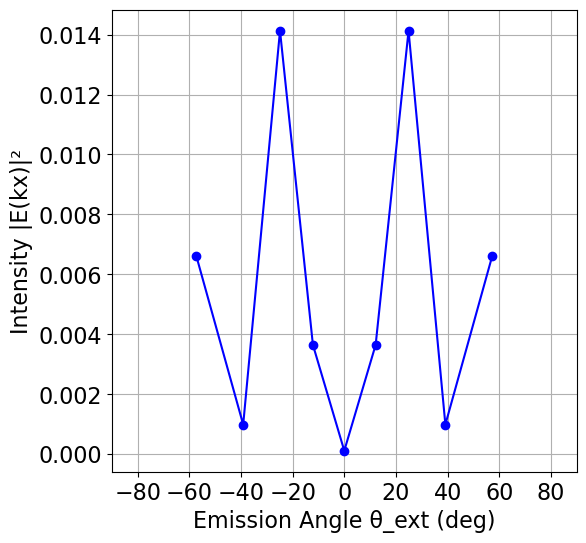

In [44]:
# 외부 kx, k0 계산은 그대로 두고
n1 = 2.6               # 내부 매질 굴절률
theta_ext = np.arcsin(kx / k0)               # 외부 방출각
theta_int = np.arcsin(kx / (1 * k0))        # 내부 진행각
theta_ext_deg = np.degrees(theta_ext)
theta_int_deg = np.degrees(theta_int)

# 내부 전파 모드만 보기 위한 마스크
theta_c = np.degrees(np.arcsin(1/n1))        # ≈22.6°
# mask_int = np.abs(theta_int_deg) <= theta_c

plt.figure(figsize = (6,6))
plt.plot(theta_ext_deg, I_k, 'bo-')
plt.xlabel('Emission Angle θ_ext (deg)',fontsize = fontlabel)
plt.ylabel('Intensity |E(kx)|²',fontsize = fontlabel)

plt.xticks(fontsize = fontlabel)
plt.yticks(fontsize = fontlabel)

plt.xlim(-90, 90)
plt.grid(True)
plt.show()


/tmp/ipykernel_7255/2401257435.py:16: RuntimeWarning: invalid value encountered in arcsin
  angle = np.arcsin(kx/k0)


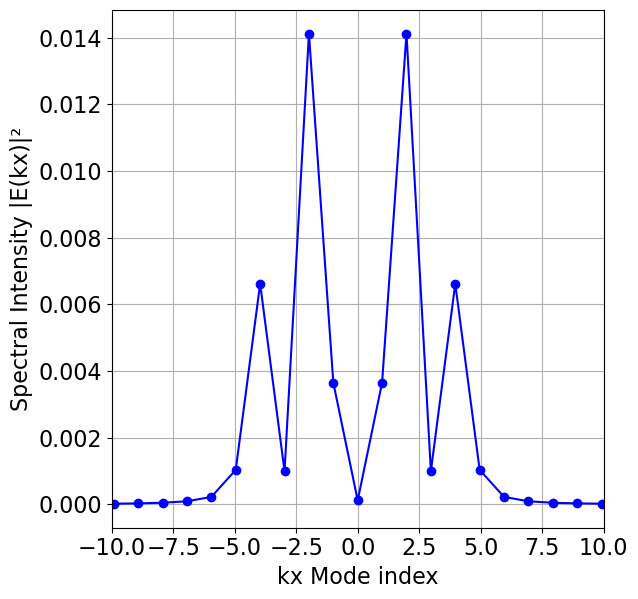

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) DFT 필드 (complex 1D array)
E = dft_fields_array
N = len(E)
dx = 1.0 / resolution    # 공간 샘플 간격
k0 = 2 * np.pi * fcen    # 진공 파수

# 2) kx 벡터 (rad/unit 길이)
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# 3) 공간 FFT → E(kx)
E_k = np.fft.fftshift(np.fft.fft(E)) / N

angle = np.arcsin(kx/k0)
theta_angle = np.degrees(angle)

mode = kx*(design_region_width/(2*np.pi))
mode

# 4) 세기 계산
I_k = np.abs(E_k)**2

fontlabel = 16

# 5) 모든 데이터 플롯
plt.figure(figsize=(6,6))
plt.plot(mode, I_k, 'bo-')
plt.xlabel('kx Mode index', fontsize=fontlabel)
plt.ylabel('Spectral Intensity |E(kx)|²', fontsize=fontlabel)
# plt.title('Full k-spectrum (no masking)', fontsize=fontlabel)
plt.grid(True)
plt.tight_layout()
plt.xlim(-10,10)
plt.xticks(fontsize=fontlabel)
plt.yticks(fontsize=fontlabel)
plt.show()


In [33]:
np.sin(np.pi*90/180)

1.0

In [36]:
np.arcsin(1/2.6 * np.sin(np.pi*22.6/180))

0.14834942955242192

In [ ]:
import numpy as np

# ── 사용자 설정 ──
n1 = 2.6                     # 입사 매질 굴절률
n2 = 1.0                     # 송출 매질 굴절률
fcen = 1.0                   # 중심 주파수 (unit⁻¹)
W    = design_region_width   # 구조 폭 (same unit as λ0)

# ── 계산 ──
lambda0  = 1/fcen
m_max    = n2 * W / lambda0   # 전파 가능한 최대 모드 지수

# 정수 모드 리스트
modes = np.arange(-int(np.floor(m_max)),
                  int(np.floor(m_max))+1)

print(f"전파 가능한 모드 지수 범위: |m| ≤ {m_max:.2f}")
print("정수 모드 인덱스:", modes)


전파 가능한 모드 지수 범위: |m| ≤ 2.40
정수 모드 인덱스: [-2 -1  0  1  2]


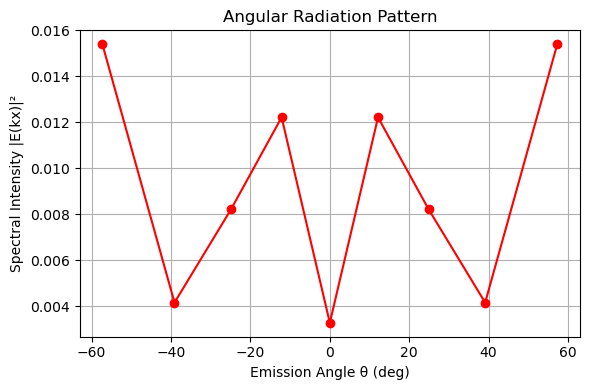

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# dft_fields_array: 시뮬레이션에서 얻은 DFT 필드 (complex 1D array)
N  = len(dft_fields_array)
dx = 1.0 / resolution      # 공간 샘플링 간격
k0 = 2 * np.pi * fcen      # 진공 파수

# 1) kx 벡터 생성 (rad/unit 길이)
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# 2) 공간 FFT → E(kx)
E_k = np.fft.fftshift(np.fft.fft(dft_fields_array)) / N

# 3) 전파 모드(Propagating modes)만 골라내기 (임계각 이내)
mask = np.abs(kx) <= k0

# 4) 각도 변환
theta = np.arcsin(kx[mask] / k0)      # 라디안
theta_deg = np.degrees(theta)         # 도(deg)

# 5) 스펙트럼 세기 계산
I_theta = np.abs(E_k[mask])**2

# 6) 방사각 분포 플롯
plt.figure(figsize=(6,4))
plt.plot(theta_deg, I_theta, '-ro')
plt.xlabel('Emission Angle θ (deg)')
plt.ylabel('Spectral Intensity |E(kx)|²')
plt.title('Angular Radiation Pattern')
plt.grid(True)
# plt.xlim(-40, 40)
plt.tight_layout()
plt.show()
